# Tutorial with graph_tran

We illustrate the core functionality of the ``graph_tran`` package using a simple numerical example. We will go over how to load a Markov chain for analysis, and how to compute mean first passage times between endpoint macrostates of interest using the graph transformation algorithm.

In [3]:
#library code
import graph_tran
from graph_tran import ktn_io as kio
from graph_tran import gt_tools as gt
from graph_tran import fpt_stats as fpt
from graph_tran import conversion as convert
from graph_tran.dimred.ktn_analysis import *
#other modules
import numpy as np
import scipy as sp
import scipy.linalg as spla 
from scipy.sparse.linalg import eigs
from scipy.sparse import csr_matrix
from scipy.linalg import eig
from scipy.linalg import expm
from scipy.interpolate import CubicSpline
from pathlib import Path
import pandas as pd
import os
import subprocess
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

Using tqdm package for pretty progress bars!


# Weiss Chain

Consider an 11-state unbranched chain with nearest neighbor connections. Weiss (1967) *Adv. Chem. Phys.* demonstrated that the inter-microstate mean first passage times (MFPTs) are exactly solvable via a recursion relation. We implement this recursion relation below, and compare the exact result to numerical methods for computing MFPTs, including graph transformation and linear algebra approaches.

In [4]:
""" Define variables needed to calculate rates as a function of temperature"""
path = Path('KTN_data/chain')
mindata = np.loadtxt(path/'min.data')
tsdata = np.loadtxt(path/'ts.data')

nmin = mindata.shape[0]
emin = mindata[:,0]
fvibmin = mindata[:, 1]
hordermin = mindata[:, 2]

ets = np.zeros((nmin, nmin))
fvibts = np.zeros((nmin, nmin))
horderts = np.ones((nmin, nmin))
exist = np.zeros((nmin, nmin))

for i in range(tsdata.shape[0]):
    j1 = int(tsdata[i, 3]) - 1
    j2 = int(tsdata[i, 4]) - 1
    exist[j1, j2] = 1
    exist[j2, j1] = 1
    ets[j1, j2] = tsdata[i, 0]
    ets[j2, j1] = tsdata[i, 0]
    fvibts[j1, j2] = tsdata[i, 1]
    fvibts[j2, j1] = tsdata[i, 1]
    horderts[j1, j2] = tsdata[i, 2]
    horderts[j2, j1] = tsdata[i, 2]


In [5]:
def Kmat(temp):
    """Return a rate matrix, (nmin x nmin) for specified temperature."""
    K = np.zeros((nmin, nmin), dtype=np.longdouble)
    for j in range(nmin):
        vib = np.exp((fvibmin - fvibts[:,j])/2).astype(np.longdouble)
        order = hordermin/(2*np.pi*horderts[:,j])
        nrg = np.exp(-(ets[:,j] - emin)/temp).astype(np.longdouble)
        K[:, j] = exist[:, j]*vib*order*nrg

    K = K.T
    for i in range(nmin):
        K[i, i] = -np.sum(K[:,i])
    #return transpose since ts.data assumes i->j and we want i<-j
    return K

def peq(temp):
    """Return equilibrium probabilities for specified temperature."""
    zvec = np.exp(-fvibmin/2)*np.exp(-emin/temp)/hordermin
    zvec = zvec.astype(np.longdouble)
    return zvec/np.sum(zvec)

#Compute matrix of MFPTs with the analytical Weiss formulae
def weiss(temp):
    """Return the matrix of mean first passage times using the recursive
    formulae in Weiss (1967) Adv. Chem. Phys. 13, 1-18."""
    K = Kmat(temp)
    def eta(j):
        if j == 0:
            return 0
        else:
            return (K[j, j-1]*eta(j-1) + 1)/K[j-1, j]

    def theta(j):
        if j==0:
            return 1
        else:
            return theta(j-1)*K[j, j-1]/K[j-1, j]

    etavec = [eta(j) for j in range(0, nmin-1)]
    thetavec = [theta(j) for j in range(0, nmin-1)]
    tmean_oneton = lambda n: (eta(n)/theta(n))*np.sum(thetavec[0:n]) - np.sum(etavec[0:n]) 

    def xeta(j):
        if j == nmin-1:
            return 0
        else:
            return (K[j, j+1]*xeta(j+1) + 1)/K[j+1, j]

    def xtheta(j):
        if j == nmin-1:
            return 1
        else:
            return xtheta(j+1)*K[j, j+1]/K[j+1, j]

    xetavec = [xeta(j) for j in range(1, nmin)]
    xthetavec = [xtheta(j) for j in range(1, nmin)]
    tmean_nmintoone = lambda n: (xeta(n)/xtheta(n))*np.sum(xthetavec[n:nmin-1]) - np.sum(xetavec[n:nmin-1]) 
    mfpt = np.zeros((nmin, nmin), dtype=np.longdouble)
    for i in range(0, nmin):
        for j in range(0, i):
            mfpt[i][j] = tmean_oneton(i) - tmean_oneton(j)
        for j in range(i+1, nmin):
            mfpt[i][j] = tmean_nmintoone(i) - tmean_nmintoone(j)
    return mfpt

## The one-dimensional energy landscape

Let's plot the landscape of the 11-state unbranched chain by interpolating between the discrete stationary points. The minima in the $\mathcal{A}$ set are colored in red, the minima in the $\mathcal{B}$ set are colored in blue, and the intervening minima $\mathcal{I} = (\mathcal{A}\cup\mathcal{B})^\mathsf{c}$ are colored in black.

Text(0, 0.5, 'Energy')

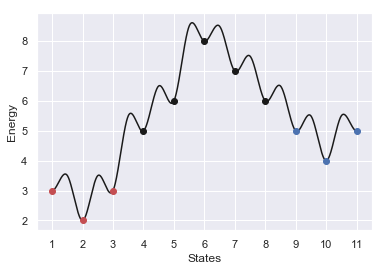

In [6]:
#There are 11 potential energy minima and 10 transition states connecting them
stat_pts = np.zeros((2*len(emin) - 1, )) 
stat_pts[::2] = emin
stat_pts[1:-1:2] = tsdata[:,0]
states = np.arange(1, 11.5, 0.5)
xrange = np.linspace(1, 11, 1000)
#interpolate between the stationary points
cs = CubicSpline(states, stat_pts, bc_type='clamped')
fig, ax = plt.subplots()
ax.plot(xrange, cs(xrange), 'k')
#minima in A set
ax.plot(states[[0, 2, 4]], stat_pts[[0, 2, 4]], 'ro')
#minima in I set
ax.plot(states[6:16:2], stat_pts[6:16:2], 'ko')
#minima in B set
ax.plot(states[[16, 18, 20]], stat_pts[[16, 18, 20]], 'bo')
ax.set_xticks(np.arange(1, 12, 1))
ax.set_xlabel('States')
ax.set_ylabel('Energy')

## Setting up a GT calculation

To set up a graph transformation calculation, we need to specify the nodes that belong to the $\mathcal{A}$ and $\mathcal{B}$ sets, which are the endpoint macrostates of interest. This can be done using the "min.A" and "min.B" files, where the first line indicates the number of nodes in the set, and the subsequent lines contain the IDs (1-indexed) of the nodes belonging to that set. These files are read in by the ``graph_tran.ktn_io.load_AB()`` function.
 
The GT algorithm requires a branching probability matrix $\textbf{B}$ and a vector specifying the inverse waiting times, or escape rates, of all nodes in the Markov chain. Both of these quantities can be computed from the transition rates (continuous-time) or transition probabilities (discrete-time) connecting the nodes in the Markov chain. There are three possible ways to load in a Markov chain for analysis:

1. Read in a "min.data" and "ts.data" file. These files are meant specifically for creating and analyzing Markov chains from the energy landscape; the format of these files are described in the documentation for the ``graph_tran.ktn_io`` package. The ``graph_tran.ktn_io.load_mat()`` function will then calculate Arrhenius transition rates from unimolecular rate theory and return the quantities necessary for a GT calculation.


In [7]:
#Specify the temperature at which to compute the Arrhenius transition rates
temp = 1.0
beta = 1./temp
# B is the sparse branching probability matrix (used in GT)
# K is the sparse rate matrix
# N is the number of nodes in the largest connected component
B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=Path('KTN_data/chain'), beta=beta)
#escape rates of the nodes (used in GT)
escape_rates = np.ravel(K.sum(axis=0))
#free energies of the nodes, used to compute Boltzmann
BF = beta*u-s
BF -= BF.min()
rho = np.exp(-BF)
rho /= rho.sum()
print("Equilibrium occupation probabilities: ", rho)
#load in the A and B sets
AS, BS = kio.load_AB(path,index_sel)
#these are boolean arrays with elements = True for the nodes that belong to each set
print("States in A: ", AS)
print("States in B: ", BS)
#compute the MFPTS between A<->B
#nodes in the A and B sets initialized to their local equilibrium occupation probabilities
df = fpt.compute_rates(AS, BS, B, escape_rates=escape_rates, K=K, BF=BF, fullGT=True, dense=False)
df

Equilibrium occupation probabilities:  [0.17803748 0.48395605 0.17803748 0.02409475 0.00886396 0.00119961 0.00326087 0.00886396 0.02409475 0.06549633 0.02409475]
States in A:  [ True  True  True False False False False False False False False]
States in B:  [False False False False False False False False  True  True  True]


,MFPTBA,MFPTAB
0,33524.360033,4889.353724


2. If you already have a transition rate matrix $\textbf{K}$ where $K_{ij}$ are the $i \leftarrow j$ inter-microstate transition rates and the diagonal elements $K_{ii} = \sum_{\gamma} K_{\gamma i}$ are such that the columns sum to zero, then we can use the ``graph_tran.ktn_io.load_CTMC()`` function to obtain the quantities necessary for a GT calculation.


In [8]:
B, escape_rates = kio.load_CTMC(Kmat(temp))
#same calculation as before, but set dense=True since B is dense
df = fpt.compute_rates(AS, BS, B, escape_rates=escape_rates, BF=BF, fullGT=True, dense=True)
df

,MFPTBA,MFPTAB
0,33524.360033,4889.353724


3. If you have a discrete-time transition probability matrix $\textbf{T}(\tau)$ estimated at a lag time $\tau$, we can use the ``graph_tran.ktn_io.load_DTMC()`` function.


In [9]:
#let's create a DTMC corresponding to the CTMC
K = Kmat(temp)
tau = 0.001 #lag time
T = expm(K*tau)
B, escape_rates = kio.load_DTMC(T, tau)
df = fpt.compute_rates(AS, BS, B, escape_rates=escape_rates, BF=BF, fullGT=True, dense=True)
df

,MFPTBA,MFPTAB
0,33524.378925,4889.354673


## Mean First Passage Times from Graph Transformation

Now that we understand how to load in a Markov chain for analysis, let's compute the mean first passage times between the $\mathcal{A}$ and $\mathcal{B}$ sets, defined as
\begin{equation} 
\mathcal{T}_{\mathcal{A}\mathcal{B}} = \frac{1}{\sum_{b \in \mathcal{B}} p_b(0)} \sum_{b \in \mathcal{B}} \frac{p_b(0) \tau^\prime_b}{1-P^\prime_{bb}},
\end{equation}
where $p_b(0)$ is the initial occupation probability of node $b$, and the prime indicates a property of the graph-transformed Markov chain for which nodes of the set $(\mathcal{A}\cup b)^\mathsf{c}$ have been eliminated. The MFPTs in both directions can be obtained from the ``graph_tran.fpt_stats`` module as illustrated below.


In [10]:
#Let's specify an initial condition where all probability density is in nodes 3 and 9
path = Path('KTN_data/chain')
initA = np.array([0., 0., 1.0])
initB = np.array([1.0, 0., 0.])
B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=path, beta=1.0)
escape_rates = np.ravel(K.sum(axis=0))
df = fpt.compute_rates(AS, BS, B, escape_rates=escape_rates, initA=initA, initB=initB, fullGT=True)
df

,MFPTBA,MFPTAB
0,33439.651495,4835.687217


Notice that these MFPTs are different from the results above, where initA and initB were automatically set
to the local Boltzmann distributions.

Alternatively, we could have just computed the inter-microstate MFPTs between the third node in the $\mathcal{A}$ set and the first node in the $\mathcal{B}$ set using the ``graph_tran.fpt_stats.compute_MFPTAB()`` function.

In [16]:
MFPTij, MFPTji = fpt.compute_MFPTAB(2, 8, B, escape_rates=escape_rates)
df = pd.DataFrame(columns=['MFPT(8<-2)', 'MFPT(2<-8)'])
df['MFPT(2<-8)'] = [MFPTij]
df['MFPT(8<-2)'] = [MFPTji]
df

,MFPT(8<-2),MFPT(2<-8)
0,33439.651495,4835.687217


## Phenomenological Rate Constants with Graph Transformation

We can also define phenomenological rate constants based on expressions from discrete path sampling:

\begin{align}
      k^{ SS}_{ {\mathcal{A}\leftarrow\mathcal{B}}}
      \equiv
      \sum_{ b\in  \mathcal{B}} \frac{C^{\mathcal{A}}_b \widehat{\pi}_b} {\tau_{b}},
%\qquad
\quad
k^{ NSS}_{ {\mathcal{A}\leftarrow\mathcal{B}}} \equiv
               \sum_{ b\in  \mathcal{B}} \frac{
               C^\mathcal{A}_b
               \widehat{\pi}_b
               }
               {
               \tau^\mathcal{I}_b
               },
%\qquad
\quad
k^{F}_{ {\mathcal{A}\leftarrow\mathcal{B}}} \equiv \sum_{ b\in  \mathcal{B}} \frac{ \widehat{\pi}_b }
                                { {\cal T}_{ \mathcal{A} b}},
      \label{kGT}
%\qquad
\quad
k^{*}_{ {\mathcal{A}\leftarrow\mathcal{B}}}
      \equiv \sum_{ b\in  \mathcal{B}} { \widehat{\pi}_b }
                                { {\cal T}_{ \mathcal{A} b}}.
\end{align}
In this hierarchy, $k^{ SS}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ is the rate when all minima in the intervening region $\mathcal{I}$
are treated in a steady state approximation, and we assume a local equilibrium distribution,  in the source
region $\mathcal{B}$, where $\widehat{\pi}_b=\pi_b/\Pi_\mathcal{B}$ and $\Pi_\mathcal{B} = \sum_{b\in\mathcal{B}} \pi_b$.
$C^\mathcal{A}_b$ is the committor probability that a trajectory leaves minimum $b\in\mathcal{B}$ and reaches $\mathcal{A}$ before
returning to $\mathcal{B}$,
and $\tau_b$ is the escape time from $b$ to any directly connected minimum.
$k^{ SS}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ neglects contributions to the first passage time from the $\mathcal{I}$ region, which
can lead to a significant systematic error.
$k^{ NSS}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ results from removing all the $\mathcal{I}$ minima by graph transformation, with $\tau^\mathcal{I}_b$ being the renormalised escape time from $b$ to any member of $\mathcal{A}\cup\mathcal{B}$.
$k^{F}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ is the rate calculated by removing all nodes in the set ($\mathcal{A}\cup b)^\mathsf{c}$, to obtain
a renormalised escape time $\tau^F_b$ from $b$ to $b\cup\mathcal{A}$, with branching probabilities $P^{\rm F}_{\mathcal{A} b}$ and
$P^{\rm F}_{bb}$, and hence a mean first passage time to $\mathcal{A}$ of
$ {\cal T}_{ \mathcal{A} b}=\tau^{\rm F}_b/P^{\rm F}_{\mathcal{A} b}$.
Finally $k^{*}_{ {\mathcal{A}\leftarrow\mathcal{B}}}$ is just the inverse of the mean first passage time $\mathcal{T}_{\mathcal{A}\mathcal{B}}$.

In [17]:
#Let's compute rates and MFPTs on the Weiss chain for a range of temperatures
invT = np.linspace(0.00001, 10, 10)
df = fpt.rates_cycle(1./invT, path, fullGT=True, MFPTonly=False)
df = df.set_index('T')
df

,MFPTBA,kSSBA,kNSSBA,kQSDBA,k*BA,kFBA,MFPTAB,kSSAB,kNSSAB,kQSDAB,k*AB,kFAB
T,,,,,,,,,,,,
100000.000000,3.667319e+02,5.362667e-03,1.532223e-03,2.805771e-03,2.726788e-03,2.733413e-03,3.591250e+02,5.362774e-03,1.532242e-03,2.842759e-03,2.784546e-03,2.788207e-03
0.899993,6.260415e+04,1.646282e-05,1.436306e-05,1.597408e-05,1.597338e-05,1.597339e-05,7.236868e+03,1.519186e-04,1.045289e-04,1.382759e-04,1.381813e-04,1.381840e-04
0.449998,5.049073e+07,1.982878e-08,1.957385e-08,1.980562e-08,1.980562e-08,1.980562e-08,5.989059e+05,1.688498e-06,1.506625e-06,1.669720e-06,1.669711e-06,1.669711e-06
0.299999,5.811251e+10,1.720875e-11,1.718610e-11,1.720800e-11,1.720800e-11,1.720800e-11,7.404429e+07,1.352234e-08,1.304026e-08,1.350543e-08,1.350543e-08,1.350543e-08
0.225000,7.504874e+13,1.332470e-14,1.332284e-14,1.332467e-14,1.332467e-14,1.332467e-14,1.035147e+10,9.661788e-11,9.548332e-11,9.660463e-11,9.660463e-11,9.660463e-11
0.180000,1.007897e+17,9.921651e-18,9.921502e-18,9.921650e-18,9.921650e-18,9.921650e-18,1.506345e+12,6.638685e-13,6.613020e-13,6.638586e-13,6.638586e-13,6.638586e-13
0.150000,1.371434e+20,7.291636e-21,7.291624e-21,7.291636e-21,7.291636e-21,7.291636e-21,2.221159e+14,4.502160e-15,4.496431e-15,4.502153e-15,4.502153e-15,4.502153e-15
0.128571,1.874204e+23,5.335597e-24,5.335596e-24,5.335597e-24,5.335597e-24,5.335597e-24,3.289449e+16,3.040023e-17,3.038750e-17,3.040023e-17,3.040023e-17,3.040023e-17
0.112500,2.564957e+26,3.898701e-27,3.898701e-27,3.898701e-27,3.898701e-27,3.898701e-27,4.878522e+18,2.049801e-19,2.049518e-19,2.049801e-19,2.049801e-19,2.049801e-19


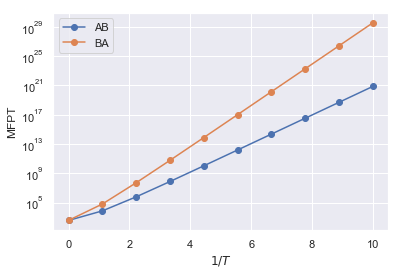

In [18]:
fig, ax = plt.subplots()
ax.plot(invT, df['MFPTAB'], '-o', label='AB')
ax.plot(invT, df['MFPTBA'], '-o', label='BA')
ax.set_xlabel(r'$1/T$')
ax.set_ylabel('MFPT')
ax.set_yscale('log')
plt.legend()